In [105]:
import math

import fruits
import matplotlib.pyplot as plt
import torch

import sainomore
from sainomore import Elissabeth, xai

# Expectation ISS

In [328]:
# def pairings(lst: list[int] | int):
#     if isinstance(lst, int):
#         lst = list(range(lst))
#     if len(lst) < 2:
#         yield []
#         return
#     a = lst[0]
#     for i in range(1, len(lst)):
#         pair = (a, lst[i])
#         for rest in pairings(lst[1:i]+lst[i+1:]):
#             yield [pair] + rest

In [329]:
def expectation_bound(T: int, p: int, alpha: float) -> float:
    if alpha > 0:
        return math.comb(T, p) * math.comb(p, 2) * math.exp(-alpha*p/2)
    return math.comb(T, p) * math.comb(p, 2) * math.exp(-alpha*p/2*(T-p))

In [330]:
def sample(n: int, T: int, cov: torch.Tensor, p: int) -> float:
    dist = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros((T,)), cov
    )
    x = dist.sample(torch.Size((n, ))).unsqueeze(1).double()
    iss_ = fruits.ISS([fruits.words.SimpleWord(p*"[1]")]).transform(x.numpy())
    return iss_[0, :, -1].mean()

### $\operatorname{Cov}(x_i,x_j)=e^{-\alpha |i-j|}$

In [331]:
def exp_cov(T: int, alpha: float) -> torch.Tensor:
    a = torch.eye(T)
    for i in range(T):
        a[*torch.tril_indices(T, T, -i)] = - i*alpha
        a[*torch.triu_indices(T, T, i)] = - i*alpha
    return torch.exp(a)

In [349]:
f"{expectation_bound(100, 5, 1e-3):.3e}"

'7.510e+08'

In [333]:
sample(1000, 1000, exp_cov(1000, 1), 2)

617.9423835481622

## Norm of Elissabeth

In [299]:
def get_model(T: int, sum_norm: bool, layer_norm: bool) -> Elissabeth:
    config = {
        "input_vocab_size": 1,
        "input_type": "vector",
        "context_length": T,
        "n_layers": 5,
        "d_hidden": 10,
        "layer_norm": layer_norm,
        "residual_stream": True,

        "lengths": [1,2,3,4,5],
        "d_values": 10,
        "values_2D": False,
        "v_norm": False,
        "sum_normalization": sum_norm,
    }
    model = Elissabeth.build(config)
    torch.nn.init.xavier_normal_(model.get_parameter("embedding.weight"))
    torch.nn.init.ones_(model.get_parameter("unembedding.weight"))
    state_dict = model.state_dict()
    for l in range(5):
        for p in range(5):
            state_dict[f"layers.{l}.levels.{p}.P_V.transform.weight"] = (
                torch.cat((p+1)*(torch.eye(10),))
            )
        state_dict[f"layers.{l}.W_O"] = torch.eye(10).unsqueeze(1)
        state_dict[f"layers.{l}.W_H"] = torch.ones(5).unsqueeze(1)
    model.load_state_dict(state_dict)
    return model

In [300]:
def sample_x(T: int, n: int, alpha: float) -> torch.Tensor:
    dist = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros((T,)), exp_cov(T, alpha)
    )
    return dist.sample(torch.Size((n, ))).unsqueeze(-1)

In [350]:
Ts = [10, 100, 1000]
alphas = [10, 1, 1e-1, 1e-2, 1e-3]
n = 100
n_layers = 5
n_lengths = 5

norm = torch.zeros((4, n, n_layers*n_lengths, len(alphas), len(Ts)))
bounds = torch.zeros((n_lengths, len(alphas), len(Ts)))

for it, t in enumerate(Ts):
    model = get_model(t, False, False)
    model_iss = get_model(t, True, False)
    model_layer = get_model(t, False, True)
    model_iss_layer = get_model(t, True, True)
    model.attach_all_hooks()
    model_iss.attach_all_hooks()
    model_layer.attach_all_hooks()
    model_iss_layer.attach_all_hooks()
    for ai, a in enumerate(alphas):
        model(sample_x(t, n, a))
        model_iss(sample_x(t, n, a))
        model_layer(sample_x(t, n, a))
        model_iss_layer(sample_x(t, n, a))
        for l in range(n_layers):
            for p in range(n_lengths):
                bounds[p, ai, it] = expectation_bound(t, p+1, a)
                iss = model.get_hook(f"layers.{l}.levels.{p}", "iss").fwd.squeeze()
                norm[0, :, l*n_layers+p, ai, it] = iss[:, -1, :].norm(dim=-1)
                iss = model_iss.get_hook(f"layers.{l}.levels.{p}", "iss").fwd.squeeze()
                norm[1, :, l*n_layers+p, ai, it] = iss[:, -1, :].norm(dim=-1)
                iss = model_layer.get_hook(f"layers.{l}.levels.{p}", "iss").fwd.squeeze()
                norm[2, :, l*n_layers+p, ai, it] = iss[:, -1, :].norm(dim=-1)
                iss = model_iss_layer.get_hook(f"layers.{l}.levels.{p}", "iss").fwd.squeeze()
                norm[3, :, l*n_layers+p, ai, it] = iss[:, -1, :].norm(dim=-1)

tensor([  0.0000,  16.5546,  80.3269, 170.5225, 206.8542])

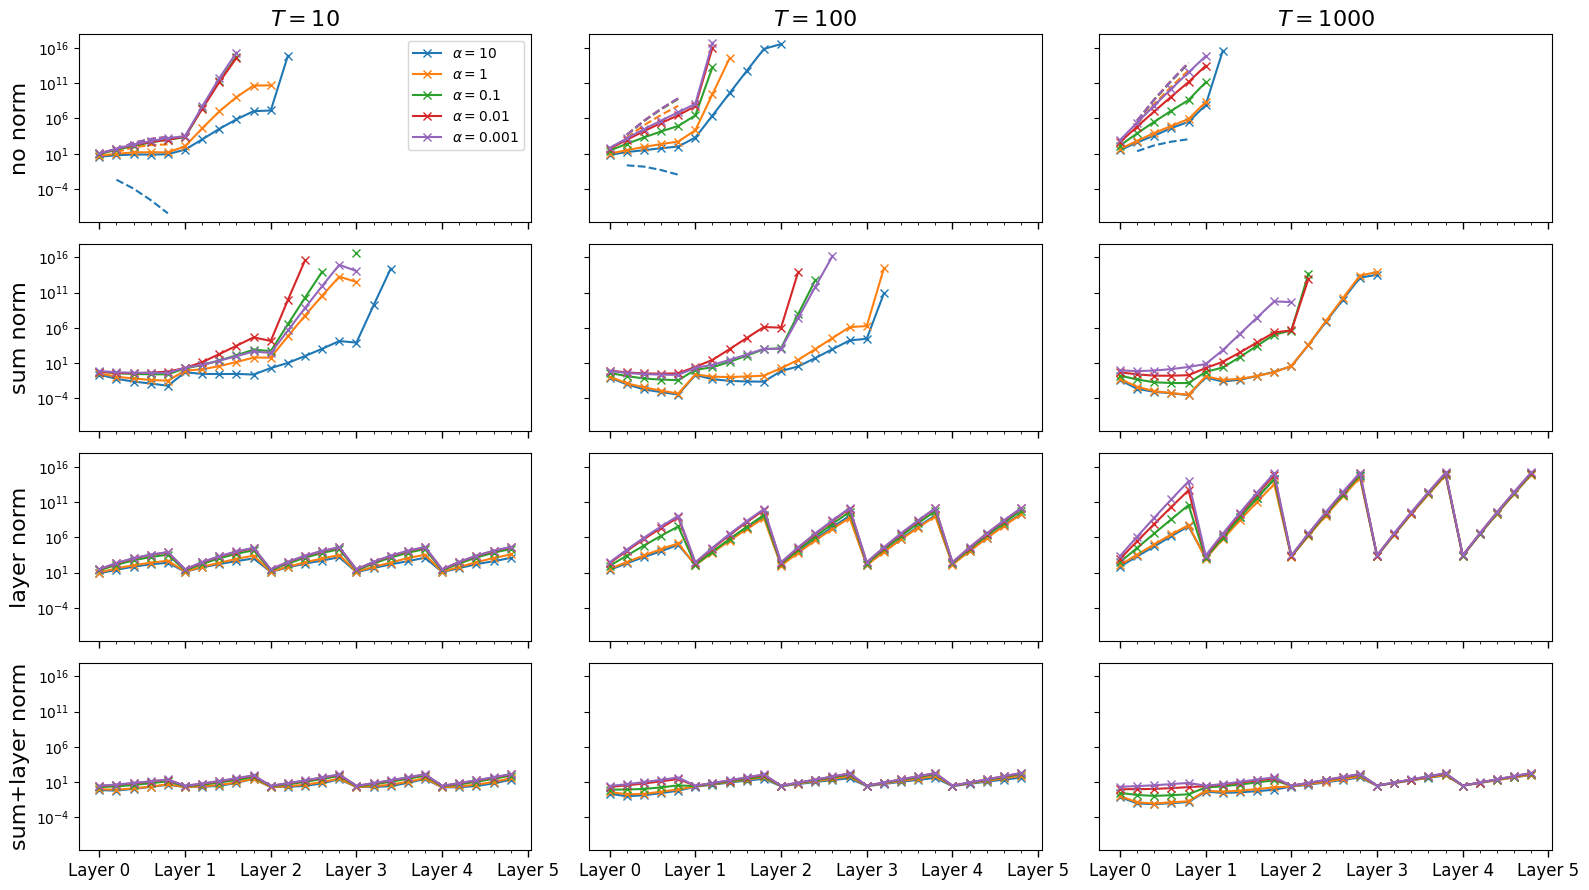

In [374]:
fig, ax = plt.subplots(4, len(Ts), figsize=(16, 9), sharex=True, sharey=True)

cm = plt.get_cmap("tab10")
for i in range(len(alphas)):
    for k in range(4):
        ax[k, 0].plot(list(range(25)), norm[k, :, :, i, 0].mean(dim=0), "-x", label=rf"$\alpha={alphas[i]}$", color=cm(i))
        ax[k, 1].plot(list(range(25)), norm[k, :, :, i, 1].mean(dim=0), "-x", label=rf"$\alpha={alphas[i]}$", color=cm(i))
        ax[k, 2].plot(list(range(25)), norm[k, :, :, i, 2].mean(dim=0), "-x", label=rf"$\alpha={alphas[i]}$", color=cm(i))
    ax[0, 0].plot(list(range(1, 5)), bounds[1:, i, 0], "--", color=cm(i))
    ax[0, 1].plot(list(range(1, 5)), bounds[1:, i, 1], "--", color=cm(i))
    ax[0, 2].plot(list(range(1, 5)), bounds[1:, i, 2], "--", color=cm(i))

ax[0, 0].legend(loc="best")
ax[0, 0].set_title("$T=10$", size=16)
ax[0, 1].set_title("$T=100$", size=16)
ax[0, 2].set_title("$T=1000$", size=16)
ax[0, 0].set_ylabel("no norm", size=16)
ax[1, 0].set_ylabel("sum norm", size=16)
ax[2, 0].set_ylabel("layer norm", size=16)
ax[3, 0].set_ylabel("sum+layer norm", size=16)
for axis in ax.flatten():
    axis.tick_params(axis='x', which='major', width=1, length=5, labelsize=12)
    axis.tick_params(axis='x', which='minor', labelsize=0)

    axis.set_xticks([l*n_lengths for l in range(0, n_layers+1)])
    axis.set_xticks(list(range(n_lengths*n_layers)), minor=True)
    axis.set_xticklabels([f"Layer {l}" for l in range(n_layers+1)])
    axis.set_yscale("log")
fig.tight_layout()
plt.savefig(
    "norm_elissabeth.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)